# Defining the U-Net

In [1]:
# Importing the required modules
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.core import Dropout
from keras.layers import Convolution2D,Input,Multiply,Concatenate,Conv2DTranspose,LeakyReLU,BatchNormalization
import tensorflow as tf

In [2]:
# An Encoder Layer
def conv2D(inp,filters):
    c=Convolution2D(filters,(5,5),strides=(2,2),padding='same',kernel_initializer='he_normal')(inp)
    c=BatchNormalization()(c)
    c=LeakyReLU(0.2)(c)
    return c

In [3]:
# A Decoder Layer
def deconv2D(inp1,inp2,filters,dp,act='relu'):
    dc=Concatenate()([inp1,inp2]) # cross connectons from encoder layer
    dc=Conv2DTranspose(2*filters,(5,5),strides=(2,2),padding='same',kernel_initializer='he_normal',activation=act)(dc) # inverse convolution
    dc=Dropout(dp)(dc)
    return dc

In [4]:
# U-Net
def MakeModel():
    inp=Input(shape=(512,256,1)) # input layer

    # Series of Encoding Layers to extract features
    c1=conv2D(inp,16)
    c2=conv2D(c1,32)
    c3=conv2D(c2,64)
    c4=conv2D(c3,128)
    c5=conv2D(c4,256)
    c6=conv2D(c5,512)

    # Series of Decoding layers to reconstruct the STFT
    c6=Conv2DTranspose(64,(5,5),padding='same',strides=(2,2),kernel_initializer='he_normal')(c6)
    dc6=deconv2D(c6,c5,128,0.5)
    dc5=deconv2D(dc6,c4,64,0.5)
    dc4=deconv2D(dc5,c3,32,0.5)
    dc3=deconv2D(dc4,c2,16,0)
    dc2=deconv2D(dc3,c1,1,0)
    out=Convolution2D(1,(5,5),padding='same',kernel_initializer='he_normal',activation='sigmoid')(dc2) #mask

    # Multiply the predicted binary mask with input STFT to get Seperated audio
    out=Multiply()([out,inp])

    return Model(inputs=inp,outputs=out)

In [5]:
model=MakeModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 128, 16  416         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

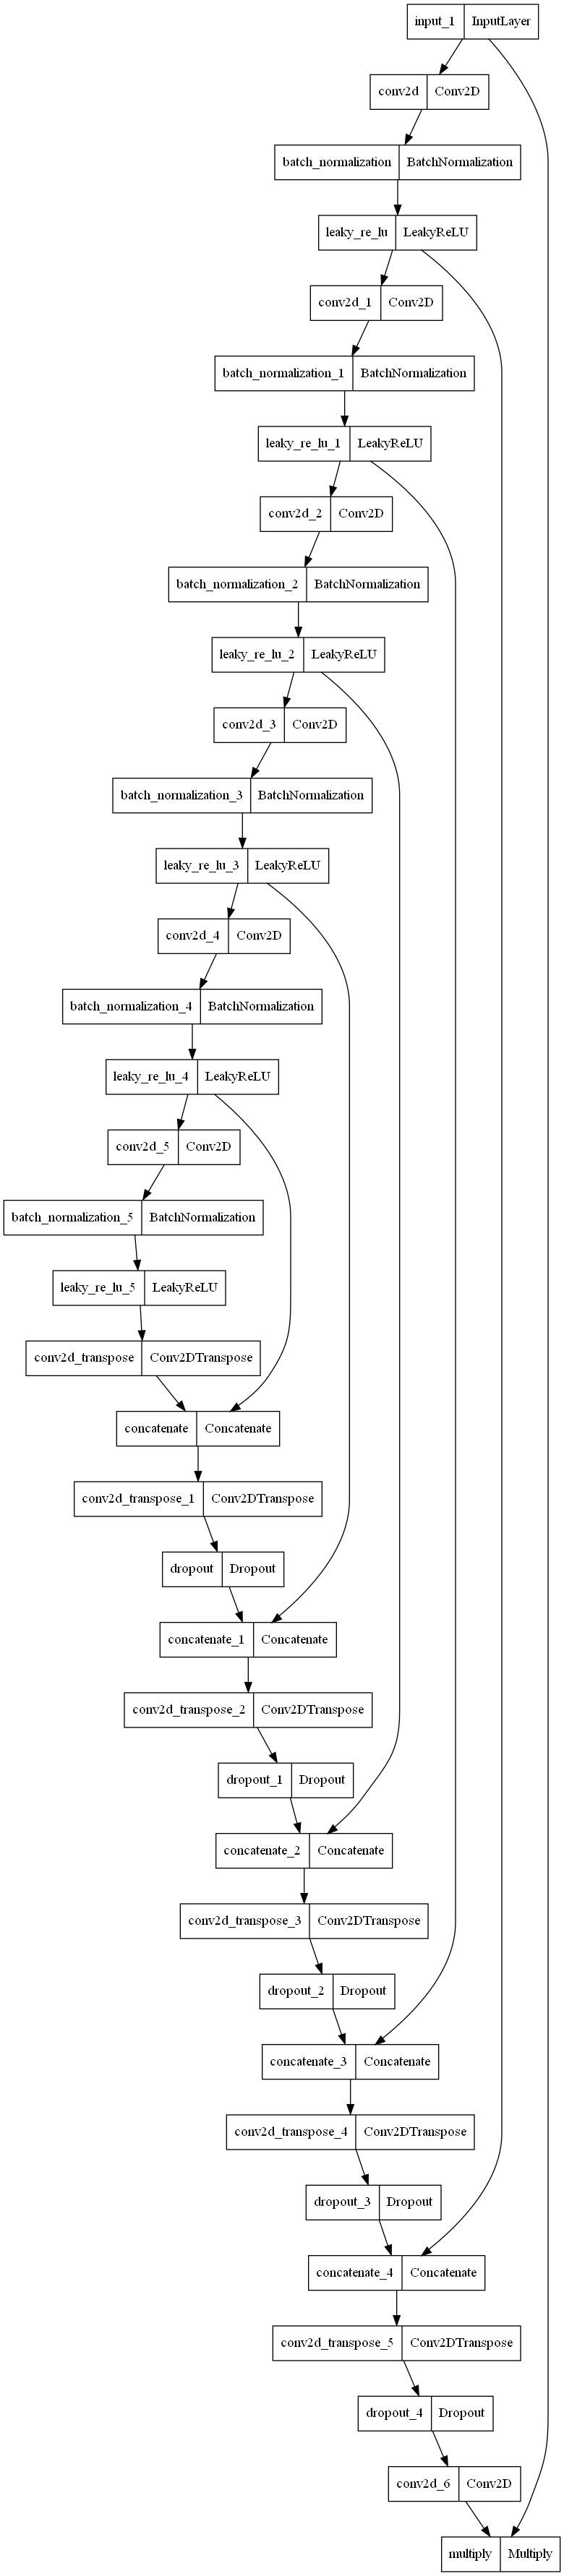

In [6]:
tf.keras.utils.plot_model(model,'model.png') # Visualization of the Model

# Audio Preprocessing


In [7]:
import musdb
import librosa
import numpy as np

mus = musdb.DB('F://musdb18/') # Dataset


In [8]:
# Splits the audio files into segments of 6 seconds and downsamples the audio to 22050 Hz
def audio(aud):
    l=aud.shape[0]
    set=l//(6*44100)
    out=np.zeros((set,132300,2))
    for i in range(set):
        s=aud[i*6*44100:(i+1)*6*44100]
        out[i]=s[::2,:]
    return out,set

In [9]:
# Takes STFT of the split audio and returns the absolute spectogram of each section
def stft(aud,set):
    s=np.zeros((2*set,512,256))
    for i in range(set):
        a0=aud[i,:,0]
        a1=aud[i,:,1]
        s[2*i]=abs(librosa.stft(a0,n_fft=1024,hop_length=512))[:-1,:-3]
        s[2*i+1]=abs(librosa.stft(a1,n_fft=1024,hop_length=512))[:-1,:-3]
    return s



# Spectogram Visualization

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot(stft,title):
    ampl_arr = librosa.amplitude_to_db(abs(stft))
    plt.figure(figsize=(15, 5))
    plt.title(title)
    librosa.display.specshow(ampl_arr, sr=22050, hop_length=512, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')

# Training

In [11]:
model.compile(loss='mse',optimizer=Adam(learning_rate=0.01),metrics=['accuracy']) # compile model 

In [12]:
# Input and Output spectograms
X=np.array([]).reshape(0,512,256)
y=np.array([]).reshape(0,512,256)

In [13]:
# Reading the data from Dataset
for i in range(20):
    audX=stft(*audio(mus[i].audio))
    audy=stft(*audio(mus[i].targets['vocals'].audio))
    X=np.insert(X,0,audX,axis=0)
    y=np.insert(y,0,audy,axis=0)


In [14]:
X.shape,y.shape

((1618, 512, 256), (1618, 512, 256))

In [15]:
model.fit(X,y,validation_split=0.15,epochs=10) # Training model

Epoch 1/10
43/43 [==============================] - ETA: 0s - loss: 1.1752 - accuracy: 0.2327

# Converting STFT to Audio

In [ ]:
import soundfile as sf

In [ ]:
# Takes inverse STFT of spectogram and writes it into a wav file
def to_audio(stft,dest):
    inv=librosa.istft(stft,hop_length=512,n_fft=1024)
    sf.write(dest,inv,22050)


# Example

In [ ]:
sample=mus[0]

mix=sample.audio
vocal=sample.targets['vocals'].audio

In [ ]:
split_stft_mix=stft(*audio(mix))
split_stft_vocal=stft(*audio(vocal))


In [ ]:
plot(split_stft_mix[0],'Spectogram of Mix Music')
plot(split_stft_vocal[0],'Spectogram of Mix Vocals')

In [ ]:
to_audio(split_stft_mix[0],'mix.wav')
to_audio(split_stft_vocal[0],'vocal.wav')